We use the [naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to approach a text classification problem, namely, given the title and a short summary of a news article, we would like to determine the category that the article belongs to (e.g., politics, sports, etc.).  The dataset we will explore is a set of about 210k news articles from the Huffington Post published between 2012 and 2022.  This dataset was prepared by [Rishabh Misra](https://arxiv.org/abs/2209.11429) and is available also on [Kaggle](https://www.kaggle.com/datasets/rmisra/news-category-dataset).  

For each of the articles, the dataset contains the title of the article as well a a short description of the article.  There are also category labels from 42 different classes.  In this notebook, we will just examine the five categories with the largest representation in the dataset (politics, wellness, entertainment, travel, and style & beauty) -- there are around 90k articles that fit into these categories.   

The following cell loads the data and adds an additional column into the dataset where we concatenate the column containing the headlines and the column containing the short descriptions.  

The goal of this notebook is to carefully examine the hyperparameter space for the naive Bayes model on this dataset and to see the influence of each hyperparameter on the accuracy of the resulting model.  

In [108]:
from itertools import compress

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

RANDOM = 42
PATH = "data/News_Category_Dataset_v3.json"
cats = ["POLITICS", "WELLNESS", "ENTERTAINMENT", "TRAVEL", "STYLE & BEAUTY"]

df = pd.read_json(PATH, lines=True)
df = df[df.category.isin(cats)]
df.reset_index(drop=True, inplace=True)
df.drop(labels=["link", "authors", "date"], axis=1, inplace=True)
df["combined"] = pd.Series([h + ' ' + d for h,d in zip(df["headline"], df["short_description"])], 
                                index=df["headline"].index.copy())

X_train, X_test = train_test_split(df, train_size=0.8, random_state=RANDOM, stratify=df["category"])
y_train, y_test = X_train["category"], X_test["category"]
X_train.drop(labels=["category"], axis=1, inplace=True)
X_test.drop(labels=["category"], axis=1, inplace=True)


We now plot the distribution of the different classes, noting that there is some imbalance.  This imbalance is the reason we did a stratified train test split in the previous cell.

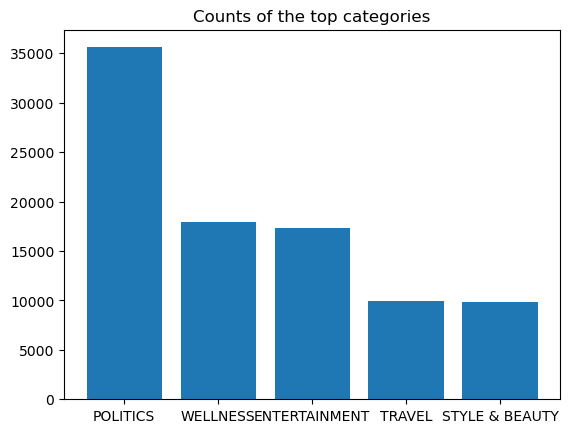

In [109]:
import matplotlib.pyplot as plt

df[df.category == "POLITICS"].shape[0]
counts = [df[df.category == cat].shape[0] for cat in cats]

plt.bar(cats, counts)
plt.title("Counts of the top categories")  
plt.show()


For preprocessing the text files, we will the [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model) (with some modifications discussed later).  The naive Bayes classifiers that we will use for the construction of our base models have a theoretical foundation resting on the assumption that the features (in our case the various word counts/appearances) follow a certain distribution when conditioned on a given class.  The parameters of these distributions are estimated from the data as well as the probabilities of each class.  Our classifier assigns to each feature observation the class that it finds likely conditioned on that feature observation.  This is computed by Bayes rule which is used to flip the conditioning and use the fit parameters to determine which class is most likely according to the model.  The result is that the classifier outputs a probability vector with entries corresponding to the probabilities of each class given the feature observation.  

In the multinomial naive Bayes model, the assumption is that the features follow a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) when conditioned on a given class (and where the $n$ parameter in the distribution does not need to be estimated as it is determined by the features and hence not needed by the classifier).  If we have $d$ features (i.e., unique words that we count )which we denote $X = (X_1,\ldots ,X_d)$ and $k$ classes which we denote $c_1, \ldots,c_k$, then the training of the multinomial naive Bayes classifier involves estimating $P(C_1), \ldots,P(C_k)$ and $P(X=x | C = c_i)$.  We assume that $X | C=c_i$ follows a multinomial distribution with parameters $p_{ij}$ for $1 \leq j \leq d$.  The classification is then
$$
c(x_1, \ldots,x_d) = \arg\max_i P(C_i) * p_{i1}^{x_1}\cdots p_{id}^{x_d}
$$
The parameters are estimated with $P(C_i)$ being the number of articles in class $i$ divided by the size of the training set, and $p_{ij}$ is the number of occurences of word $j$ across all articles in class $i$ divided by the sum of all of the lengths of the articles in class $i$.  

A theoretical breakdown of the time and space usage of multinomial naive Bayes is given in the following table:

|  Process     | Time                                   | Space       |
| -----------  | -----------                            | ----------- |
| Preprocessing| $O(\text{sum of lengths of articles})$ | $O(d)$        |
| Training     | $O(\text{sum of lengths of articles})$ | $O(d*k)$      |
| Evaluating   | $O(\text{length of article} + d*k^2)$  | $O(1)$        |

The main takeaway is that naive Bayes is fast.  

The other naive Bayes classifier that we will use is the Bernoulli naive Nayes classsifier which assumes that conditioned on being in a specific class, the different features $X_j$ are independent Bernoulli random variables.  The time complexity and overall structure of the model is otherwise very similar to multinomial naive Bayes.  

The following cell defines our base model training pipeline in the function `train`.  Several of the parameters (`alpha`, `ngram_range`, `tf`, `tfidf`) are used for modification of the vanilla naive Bayes model that we have just described and they will be introduced shortly.  We then go on to define functions to obtain the accuracy of our models, make predictions with our models, and we construct a few models.  

In [110]:
def train(X_train, y_train, 
          max_features, 
          distribution='multinomial', 
          data_source='headline', 
          alpha=1.0, 
          ngram_range=(1,1),
          tf=False,
          tfidf=False):
    '''Train a naive Bayes model taking the top appearing ``max_features`` many words
    from the training corpus.  If ``distribution`` is "multinomial" (default) then 
    fit a multinomial naive Bayes model. Otherwise, you can set ``distribution`` to 
    be "bernoulli" and a Bernoulli naive Bayes model is fit.    

    The ``data_source`` is either "headline", "short_description" or "combined"
    to indicate which column is used for the training.   

    The parameter ``alpha`` is the smoothing parameter and  ``ngram_range`` indicates 
    the range of ngrams to be computed in the preprocessing.  When doing multinomial
    naive Bayes, setting ``tf`` to True uses term frequencies and if ``tfidf`` is also 
    set to True, then these term frequentcies are scaled by the inverse document 
    frequencies.  
    '''
    clf = MultinomialNB(alpha=alpha) if distribution=='multinomial' else BernoulliNB(alpha=alpha)
    vect = ColumnTransformer([(data_source, CountVectorizer(stop_words='english', 
                                                            max_features=max_features,
                                                            ngram_range=ngram_range), data_source)],
                             remainder='drop', verbose_feature_names_out=False)

    tft = TfidfTransformer(use_idf=tfidf)

    # boolean list to determine if we include tf
    cmp = [True, tf, True] 
    pipeline = [('vect', vect),
                ('tft', tft),
                ('clf', clf)]
    pipeline = list(compress(pipeline, cmp))

    text_clf = Pipeline(pipeline)
    text_clf.fit(X_train, y_train)
    return text_clf


In [111]:
def test_accuracy(X_test, y_test, text_clf):
    '''Returns the test accuracy of ``test_clf``.'''
    predicted = text_clf.predict(X_test)
    return np.mean(predicted == y_test)

def predictions(docs_new, text_clf):
    '''Given an array of strings as ``docs_new``, print the predicted labels and 
    the prediction probability vector for the predicitions of ``test_clf``
    on the strings.  
    '''
    predicted = text_clf.predict(docs_new)
    predicted_probas = text_clf.predict_proba(docs_new)

    # Print the models predictions for these new texts.
    for doc, category, proba in zip(docs_new, predicted, predicted_probas):
        print(f'{doc} => {category}, {proba}')


In [112]:
max_features = 30000

data_sources = ["headline",
                "short_description",
                "combined"]

for data_source in data_sources:
    clf = train(X_train, y_train, max_features, data_source=data_source)
    print(f'{data_source} model accuracy = {test_accuracy(X_test, y_test, clf)}')

# Try out the classifier on some new headlines.  
#docs_new = ['Love is good', 'OpenGL on the GPU is fast', 'Golden Globes are coming']
#predictions(docs_new, text_clf_description)
#predictions(docs_new, text_clf_headline)


headline model accuracy = 0.8759172413793104
short_description model accuracy = 0.7712551724137932
combined model accuracy = 0.9051034482758621


One useful visualization for model validation of classifiers is the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) which shows the performance of a classifier across the different classes.  Structure in the confusion matrix can point toward potential approaches to model improvement.  Here we display the confusion matrix for our naive Bayes model trained on the headlines of the news articles.  There is no immediate structure, although we get a sense of which classes are more difficult for the classifier to differentiate.  

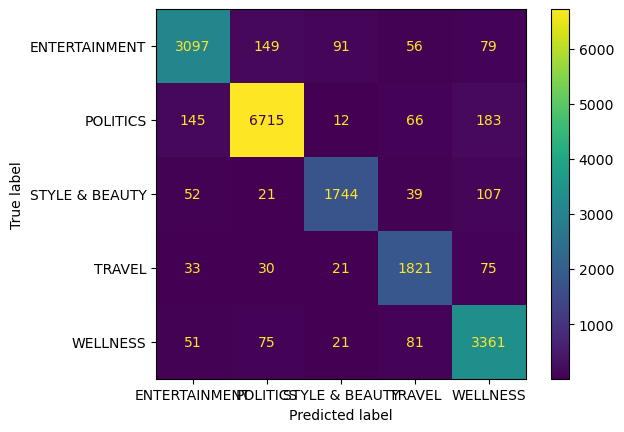

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = clf_headline
predictions  = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot()
plt.show()


The following cell explores the relationship between the max number of features, the data source, and the distribution used for the classifier.  We find that Bernoulli and multinomial naive Bayes perform similarly (although we will soon introduce some modifications to the models to further explore this), that the headline data is more descriptive than the short description, and that we obtain better models when including both the short description and the headline.  We will explore other techniques for incorporating both data sources shortly.  

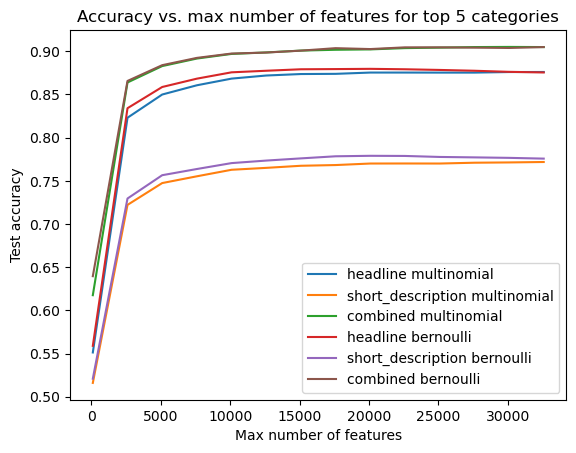

In [114]:
max_features = np.arange(100, 35100, 2500)
#max_features = np.arange(100, 85100, 2500)

parameters = [("headline",          "multinomial"),
              ("short_description", "multinomial"),
              ("combined",          "multinomial"),
              ("headline",          "bernoulli"),
              ("short_description", "bernoulli"),
              ("combined",          "bernoulli")]

for data_source, distribution in parameters:
    label = data_source + ' ' + distribution
    accuracies = [test_accuracy(X_test, y_test,
                                train(X_train, y_train,
                                      max_features=mf,
                                      data_source=data_source,
                                      distribution=distribution)) for mf in max_features]
    plt.plot(max_features, accuracies, label=label)

plt.xlabel("Max number of features") 
plt.ylabel("Test accuracy")
plt.title("Accuracy vs. max number of features for top 5 categories")  
plt.legend()  
plt.savefig('figs/various_max_features')
plt.show()


A smoothing parameter, usually denoted $\alpha$, is typically used with naive Bayes (both in the Bernoulli and multinomial flavors).  The default value of $\alpha$ is 
$1.0$ in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) (see also [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)) in which case, when estimating the parameters for the distribution of the features conditioned conditioned on being in that class, we add a single additional entry in that class that has exactly one of each of the words in the available vocabulary.  The presence of this single entry causes the parameters for the distributions to never be exactly $0.0$ which would result in it being impossible for a new datapoint to be assigned to a class if it had a word that did not appear in the training corpus for that class (except possibly if it has words in none of the classes and by chance is assigned to the correct class).  

More generally, by choosing another value of $\alpha$, the parameters for the distribution in the multinomial setting are computed as if there was an extra entry in class with all word counts equal to $\alpha$.  Therefore, taking a very large value of $\alpha$ mutes the data and results in the estimated distributions being uniform (and therefore the classification being entirely determined by the estimated prior).  The Bernoulli case behaves similarly and the general name for this technique is [additive (or Laplace smoothing)](https://en.wikipedia.org/wiki/Additive_smoothing).  

The next cell produces a plot that compares the log of $\alpha$ with the classification accuracy for the different variations of naive Bayes with the different data sources.  The result we see is that the default setting of $\alpha = 1.0$ is close enough to optimal although by using $\alpha = 0.1$ we appear to get better performance out of the Bernoulli naive Bayes model which then slightly outperforms the multinomial model.     

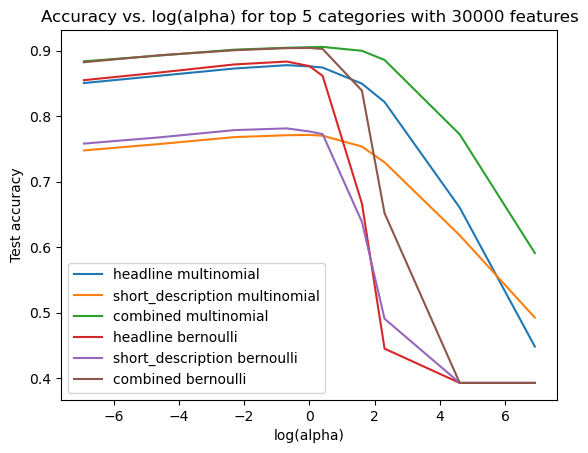

In [115]:
max_features = 30000

alphas = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 5, 10, 100, 1000]

for data_source, distribution in parameters:
    label = data_source + ' ' + distribution
    accuracies = [test_accuracy(X_test, y_test,
                                train(X_train, y_train,
                                      max_features=max_features,
                                      data_source=data_source,
                                      distribution=distribution,
                                      alpha=alpha)) for alpha in alphas]
    plt.plot(np.log(alphas), accuracies, label=label)

plt.xlabel("log(alpha)") 
plt.ylabel("Test accuracy")
plt.title(f'Accuracy vs. log(alpha) for top 5 categories with {max_features} features')  
plt.legend()  
plt.savefig('figs/various_alphas')
plt.show()


We will now experiment with a potentially more accurate ensembling of the models trained on the headlines and the descriptions.  Previously, we have done this by just reorganizing the data and having combining the headlines and descriptions together.  Intuition and now the performance of our models suggests that the headline should be more informative about the content of the article (when considered word for word as in our models) and so perhaps we should train two models, namely the model trained on the headline and the model trained on the description, and in order to get a classifier, average together the classification predictions from the two models.  We can use a hyperparameter which we will call the ensembling parameter and denote $\mu$ to control how much weight each of the models get in the voting.  We will have the headline model predictions be given weight $\mu$ and the description model predictions be given weight $1 - \mu$.

In the terminology of sklearn, we use the [sklearn voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) with the 'soft' voting rule and with weights $\mu$ and $1-\mu$ for the weights of two base classifiers, one a Bernoulli naive Bayes model trained on the headlines and the other a Bernoulli naive Bayes model trained on the descriptions.  

For these base naive Bayes models, we use 20000 features and set $\alpha = 0.1$ which we have seen from the previous experiments are reasonable choices.  

In addition, we add incorporate the parameter `ngram_range` of the `CountVectorizer` function that we are using for preprocessing into our new model training function (`train_for_ensemble` below) as well as the parameters `tf` and `tfidf` which allow for addition of the `TfidfTransformer`.  We will discuss these shortly and use them to take a closer look at our preprocessing.  

In [116]:
from sklearn.ensemble import VotingClassifier

def train_voting(clf_headline, clf_description, mu):
    vclf = VotingClassifier(estimators=[('headline', clf_headline), ('description', clf_description)],
                            voting='soft',
                            weights=[mu, 1-mu])
    vclf.fit(X_train, y_train)
    return vclf

max_feature    = 30000
#clf_headline    = train_for_ensemble(X_train, y_train, max_features, data_source='headline')
#clf_description = train_for_ensemble(X_train, y_train, max_features, data_source='short_description')
clf_headline    = train(X_train, y_train, max_feature, distribution='bernoulli', 
                            data_source='headline', alpha=0.1)
clf_description = train(X_train, y_train, max_feature, distribution='bernoulli', 
                            data_source='short_description', alpha=0.1)

mu = 0.58
vclf = train_voting(clf_headline, clf_description, mu)

print(f'headline model accuracy    = {test_accuracy(X_test, y_test, clf_headline)}')
print(f'description model accuracy = {test_accuracy(X_test, y_test, clf_description)}')
print(f'voting model accuracy      = {test_accuracy(X_test, y_test, vclf)}')


headline model accuracy    = 0.8787862068965517
description model accuracy = 0.7785931034482758
voting model accuracy      = 0.9057103448275862


In [117]:
from joblib import dump, load

SAVED_MODEL = 'models/voting_bernoulli.joblib'
dump(vclf, SAVED_MODEL) 


['models/voting_bernoulli.joblib']

We saved the previous model as it will turn out to be the most accurate model that we come across.  The following cell graphs the effect of using different values for the weight parameter $\mu$ in the ensembling and justifies our choice of $\mu = 0.58$.  

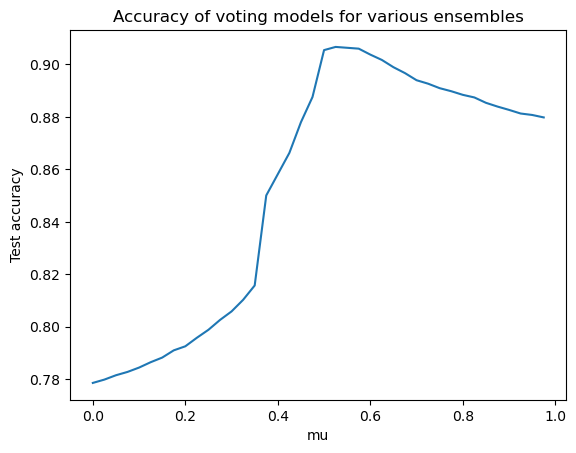

In [118]:
mu_values = np.arange(0, 1, 0.025)
accuracies = [test_accuracy(X_test, y_test, 
                            train_voting(clf_headline, clf_description, mu)) for mu in mu_values]
plt.plot(mu_values, accuracies)

plt.xlabel("mu") 
plt.ylabel("Test accuracy")
plt.title(f'Accuracy of voting models for various ensembles')  
plt.savefig('figs/tuning_mu')
plt.show()


We now experiment with the preprocessing step to see if including more than just single words (unigrams), but rather counts/appearances of pairs of words (bigrams).  In counting bigrams, the count/appearance of the pair of words "hot dog" is a single feature whereas when just counting unigrams this would correspond to two features ("hot" and "dog").  By considering not just unigrams but also bigrams, we may hope to create a model that can better understand context.  

The following cell plots the model accuracies for the Bernoulli naive Bayes models (trained on the headlines with $\alpha=0.1$) for various possible numbers of features.  We find that including bigrams (or considering bigrams alone) does not increase performance.  Similar results can be seen for the other models and hyperparameter settings.  Therefore, we will continue to just consider unigrams.  Similar results for multinomial naive Bayes show a lack of substantial improvement in that case.  

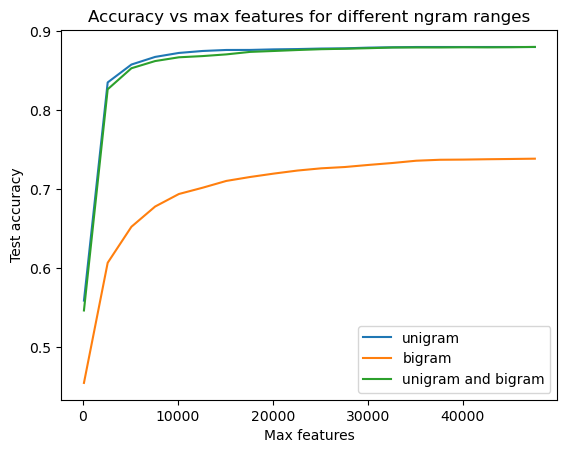

In [119]:
max_features = np.arange(100, 50100, 2500)
#alpha = 1.0
alpha = 0.1
#distribution = 'multinomial'
distribution = 'bernoulli'
data_source = 'headline'
#data_source = 'short_description'

ngram_ranges = [(1,1),     (2,2),    (1,2)]
labels       = ["unigram", "bigram", "unigram and bigram"]

for ngram_range,label in zip(ngram_ranges, labels):
    accuracies = [test_accuracy(X_test, y_test,    
                                train(X_train, y_train, 
                                      mf, 
                                      distribution=distribution,
                                      data_source=data_source,
                                      ngram_range=ngram_range, 
                                      alpha=alpha)) for mf in max_features]    
    plt.plot(max_features, accuracies, label=label)

plt.xlabel("Max features") 
plt.ylabel("Test accuracy")
plt.title(f'Accuracy vs max features for different ngram ranges')  
plt.legend()  
plt.savefig('figs/headline_unigram_bigram_various_mf')
plt.show()


When preforming preprocessing for a multinomial naive Bayes classifier for text recognition, it is common to train the classifier on the [term frequencies](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) instead of on the raw counts of each of the words.  The term frequency associated to a document is the word frequency vector of the document divided by the total length of the document.  Using these in estimating the parameters of the naive Bayes classifier can help mitigate the otherwise unbalanced effect that longer documents might have.  

The inverse document frequency of a word in a document from a collection of documents is the logarithm of the total number of documents divided by the number of documents containing that word.  It is often thought of as a measure of the relative importance of a word and the term frequencies of a document are often scaled by their inverse document frequency.  

We use the sklearn function [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to obtain the term frequencies and the inverse document frequencies from the word counts.  

The following cell plots the test accuracy of the multinomial naive Bayes model with different number of parameters using different combinations of unigrams and bigrams, trained on the word counts, term frequencies, and term frequencies times the inverse document frequencies.  

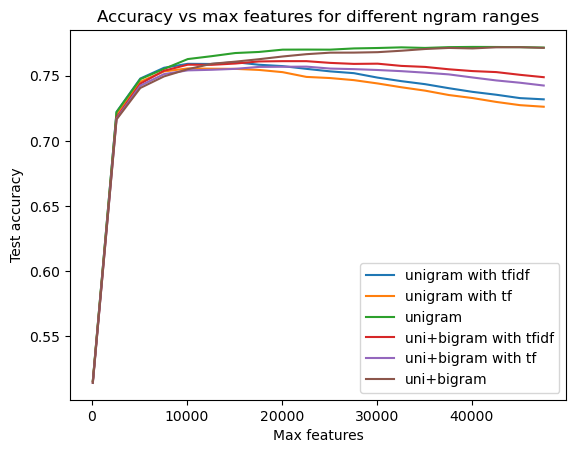

In [120]:
max_features = np.arange(100, 50100, 2500)
alpha = 1.0
distribution = 'multinomial'
#data_source = 'headline'
data_source = 'short_description'

parameters = [((1,1), True,  True,  "unigram with tfidf"   ),
              ((1,1), True,  False, "unigram with tf"      ),
              ((1,1), False, False, "unigram"              ),
              ((1,2), True,  True,  "uni+bigram with tfidf"),
              ((1,2), True,  False, "uni+bigram with tf"   ),
              ((1,2), False, False, "uni+bigram"           )]

for ngram_range,tf,tfidf,label in parameters:
    
    accuracies = [test_accuracy(X_test, y_test,    
                                train(X_train, y_train, 
                                      mf, 
                                      distribution=distribution,
                                      data_source=data_source,
                                      ngram_range=ngram_range, 
                                      alpha=alpha,
                                      tf=tf,
                                      tfidf=tfidf)) for mf in max_features]    
    plt.plot(max_features, accuracies, label=label)

plt.xlabel("Max features") 
plt.ylabel("Test accuracy")
plt.title(f'Accuracy vs max features for different ngram ranges')  
plt.legend()  
plt.savefig('figs/multinomial_tf_idf_various_mf')
plt.show()


One thing to observe in the previous plot is that by using more and more features, we are squeezing out more and more accuracy.  These features are at the tail end, words (or bigrams) that appear only once in the training data.  This would be like seeing the word "gubernatorial" in a single politics article in the training data and incorporating that as a feature.  That word is so uncommon that if we see it in a new article, it appears to be a reasonable guess that that article is also a politics article. 

So if we really want to squeeze the most out of our models, we can continue to increase the ``max_features`` parameter to incorporate these singleton words.  The following cell demonstrates the continuation of this slight improvement as we increase the number of ``max_features``.  

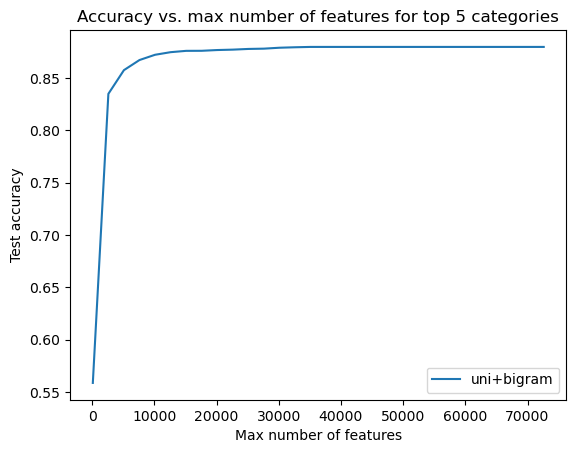

In [121]:
#max_features = np.arange(100, 35100, 2500)
max_features = np.arange(100, 75100, 2500)

accuracies = [test_accuracy(X_test, y_test,
                            train(X_train, y_train,
                                    max_features=mf,
                                    data_source="headline",
                                    alpha=0.1,
                                    distribution="bernoulli")) for mf in max_features]
plt.plot(max_features, accuracies, label=label)

plt.xlabel("Max number of features") 
plt.ylabel("Test accuracy")
plt.title("Accuracy vs. max number of features for top 5 categories")  
plt.legend()  
plt.savefig('figs/various_max_features')
plt.show()


We have built several different classifiers that try to determine the class of an article from the headline and a short description of the article.  We have compared the Bernoulli and multinomial naive Bayes models and have explored various extensions/modifications to these models.  We ultimately settled on an ensemble model that was a voting ensemble of a Bernoulli naive Bayes model trained on the headlines and another Bernoulli naive Bayes model trained on the short desriptions.  The weights in this ensemble were such that the headline was given slightly more importance than the short description.  We used a smoothing parameter to slightly dampen the base models and slightly increase their accuracy.  Using still more features (but still unigrams) would further improve our models accuracy, at the expence of training/evaluation time.